In [1]:
import pandas as pd
df_claim = pd.read_csv('claim data/train.csv')
df_claim

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,ID58588,0.355089,0.13,0.644231,C8,8794,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
58588,ID58589,1.199642,0.02,0.519231,C14,7788,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
58589,ID58590,1.162273,0.05,0.451923,C5,34738,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
58590,ID58591,1.236307,0.14,0.557692,C8,8794,1,B2,M6,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,K Series Dual jet,2,No,Yes,No,Yes,No,Drum,1197,4,Manual,5,Electric,4.8,3845,1735,1530,1335,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0


|Variable	| Description |
| --- | --- |
| policy_id |	Unique identifier of the policyholder|
| policy_tenure |	Time period of the policy|
| age_of_car |	Normalized age of the car in years|
| age_of_policyholder |	Normalized age of policyholder in years|
| area_cluster |	Area cluster of the policyholder|
| population | density	Population density of the city (Policyholder City)|
| make |	Encoded Manufacturer/company of the car|
| segment |	Segment of the car (A/ B1/ B2/ C1/ C2)|
| model |	Encoded name of the car|
| fuel_type |	Type of fuel used by the car|
| max_torque |	Maximum Torque generated by the car (Nm@rpm)|
| max_power |	Maximum Power generated by the car (bhp@rpm)|
| engine_type |	Type of engine used in the car|
| airbags |	Number of airbags installed in the car|
| is_esc |	Boolean flag indicating whether Electronic Stability Control (ESC) is present in the car or not.|
| is_adjustable_steering |	Boolean flag indicating whether the steering wheel of the car is adjustable or not.|
| is_tpms |	Boolean flag indicating whether Tyre Pressure Monitoring System (TPMS) is present in the car or not.|
| is_parking_sensors |	Boolean flag indicating whether parking sensors are present in the car or not.|
| is_parking_camera |	Boolean flag indicating whether the parking camera is present in the car or not.|
| rear_brakes_type |	Type of brakes used in the rear of the car|
| displacement |	Engine displacement of the car (cc)|
| cylinder |	Number of cylinders present in the engine of the car|
| transmission_type |	Transmission type of the car|
| gear_box |	Number of gears in the car|
| steering_type |	Type of the power steering present in the car |
| turning_radius |	The space a vehicle needs to make a certain turn (Meters) |
| length |	Length of the car (Millimetre) |
| width |	Width of the car (Millimetre) |
| height |	Height of the car (Millimetre) |
| gross_weight |	The maximum allowable weight of the fully-loaded car, including passengers, cargo and equipment (Kg) |
| is_front_fog_lights |	Boolean flag indicating whether front fog lights are available in the car or not. |
| is_rear_window_wiper |	Boolean flag indicating whether the rear window wiper is available in the car or not. |
| is_rear_window_washer |	Boolean flag indicating whether the rear window washer is available in the car or not. |
| is_rear_window_defogger |	Boolean flag indicating whether rear window defogger is available in the car or not. |
| is_brake_assist |	Boolean flag indicating whether the brake assistance feature is available in the car or not. |
| is_power_door_lock |	Boolean flag indicating whether a power door lock is available in the car or not. |
| is_central_locking |	Boolean flag indicating whether the central locking feature is available in the car or not. |
| is_power_steering |	Boolean flag indicating whether power steering is available in the car or not. |
| is_driver_seat_height_adjustable |	Boolean flag indicating whether the height of the driver seat is adjustable or not. |
| is_day_night_rear_view_mirror |	Boolean flag indicating whether day & night rearview mirror is present in the car or not. |
| is_ecw |	Boolean flag indicating whether Engine Check Warning (ECW) is available in the car or not. |
| is_speed_alert |	Boolean flag indicating whether the speed alert system is available in the car or not. |
| ncap_rating |	Safety rating given by NCAP (out of 5) |
| is_claim |	Outcome: Boolean flag indicating whether the policyholder file a claim in the next 6 months or not. |

In [2]:
print(df_claim.head())
df_claim.info()

  policy_id  policy_tenure  age_of_car  ...  is_speed_alert ncap_rating  is_claim
0   ID00001       0.515874        0.05  ...             Yes           0         0
1   ID00002       0.672619        0.02  ...             Yes           0         0
2   ID00003       0.841110        0.02  ...             Yes           0         0
3   ID00004       0.900277        0.11  ...             Yes           2         0
4   ID00005       0.596403        0.11  ...             Yes           2         0

[5 rows x 44 columns]
<class 'pandas.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  str    
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area

The types for some variables don't make any sense.

policy_id should be dropped for the feature selection.



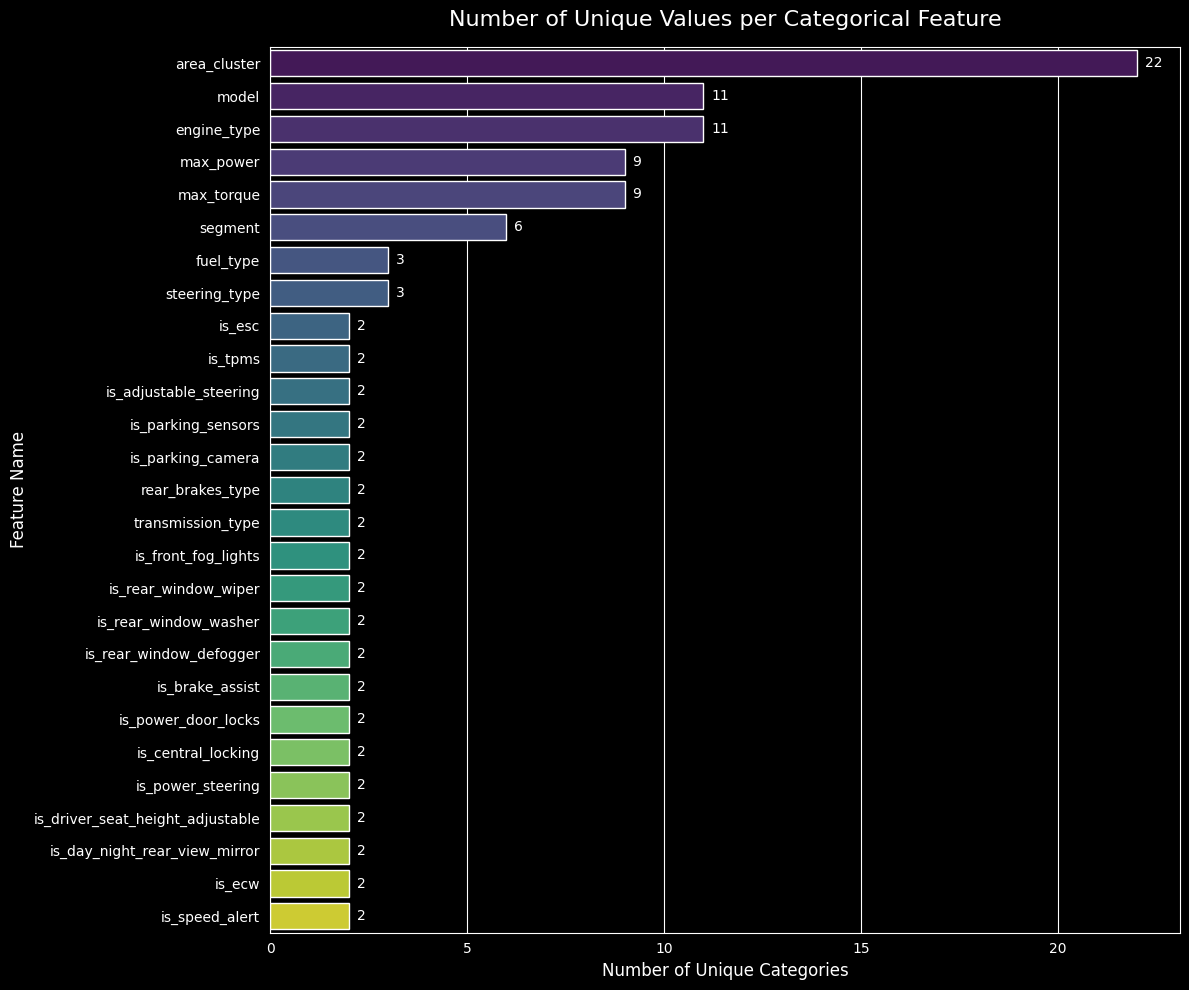

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

unique_counts = {}
for col in df_claim.columns:
    if (df_claim[col].dtype == 'object' or df_claim[col].dtype == 'str') and col != 'policy_id':
        unique_counts[col] = df_claim[col].nunique()

df_unique = pd.DataFrame(list(unique_counts.items()), columns=['Feature', 'Unique_Count'])
df_unique = df_unique.sort_values(by='Unique_Count', ascending=False)

plt.figure(figsize=(12, 10))

sns.barplot(
    x='Unique_Count',
    y='Feature',
    data=df_unique,
    palette='viridis',
    hue='Feature',
    legend=False
)

plt.title('Number of Unique Values per Categorical Feature', fontsize=16, pad=15)
plt.xlabel('Number of Unique Categories', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)

for index, value in enumerate(df_unique['Unique_Count']):
    plt.text(value + 0.2, index, str(value), va='center', fontsize=10)

plt.tight_layout()
plt.show()

We have a lot of categories per column, we are going to prevent a bloat of the matrix
also we are going to put in the biggest bucket when a category has less than a 10% of the column.

By bucketing rare categories, we are protecting the model from overfitting.
Where if not, the model will learn the exact value of the category,
and have a bad generalization performance.


In [4]:
import pandas as pd


def clean_insurance_data(df, min_frequency=0.01):
    """
    Cleans the specific car insurance dataset for statsmodels regression.
    Handles string parsing, binary mapping, rare category bucketing, and dummy encoding.
    """
    print("Starting data clean-up...")
    df_clean = df.copy()

    if 'policy_id' in df_clean.columns:
        df_clean = df_clean.drop('policy_id', axis=1)
        print("Dropped 'policy_id'.")

    print("Parsing torque and power strings into numbers...")
    regex_pattern = r'([\d\.]+).*?@.*?([\d\.]+)'

    if 'max_torque' in df_clean.columns:
        df_clean[['torque_value', 'torque_rpm']] = df_clean['max_torque'].str.extract(regex_pattern).astype(float)
        df_clean = df_clean.drop('max_torque', axis=1)

    if 'max_power' in df_clean.columns:
        df_clean[['power_value', 'power_rpm']] = df_clean['max_power'].str.extract(regex_pattern).astype(float)
        df_clean = df_clean.drop('max_power', axis=1)

    print("Mapping 'is_' columns to 1 and 0...")
    binary_cols = [col for col in df_clean.columns if col.startswith('is_') and col != 'is_claim']

    for col in binary_cols:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0})

    df_clean = df_clean.dropna()

    print(f"Bucketing rare categories (threshold: < {min_frequency * 100}% of data)...")
    categorical_cols = df_clean.select_dtypes(include=['object', 'str']).columns

    for col in categorical_cols:
        frequencies = df_clean[col].value_counts(normalize=True)
        rare_categories = frequencies[frequencies < min_frequency].index

        if len(rare_categories) > 1:
            df_clean[col] = df_clean[col].replace(rare_categories, 'Other')
            print(f"  - '{col}': grouped {len(rare_categories)} rare values into 'Other'")

        elif len(rare_categories) == 1:
            majority_class = frequencies.idxmax()
            df_clean[col] = df_clean[col].replace(rare_categories, majority_class)
            print(f"  - '{col}': absorbed 1 sparse value into majority class '{majority_class}'")

    print("Applying dummy encoding (drop_first=True)...")
    df_clean = pd.get_dummies(df_clean, drop_first=True, dtype=float)

    print("-" * 40)
    print(f"Clean-up complete! Final dataset shape: {df_clean.shape}")

    X = df_clean.drop('is_claim', axis=1)
    y = df_clean['is_claim']

    return X, y

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_correlation_heatmap(df_features, title):
    """
    Plots a highly formatted, readable correlation heatmap for large datasets.
    """
    corr = df_features.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(20, 16))

    sns.heatmap(
        corr,
        mask=mask,
        cmap='coolwarm',
        vmin=-1, vmax=1,
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .5}
    )

    plt.title(title, fontsize=20, pad=20)
    plt.tight_layout()
    plt.show()


Starting data clean-up...
Dropped 'policy_id'.
Parsing torque and power strings into numbers...
Mapping 'is_' columns to 1 and 0...
Bucketing rare categories (threshold: < 1.0% of data)...
  - 'area_cluster': grouped 6 rare values into 'Other'
  - 'model': absorbed 1 sparse value into majority class 'M1'
  - 'engine_type': absorbed 1 sparse value into majority class 'F8D Petrol Engine'
  - 'is_speed_alert': absorbed 1 sparse value into majority class 'Yes'
Applying dummy encoding (drop_first=True)...
----------------------------------------
Clean-up complete! Final dataset shape: (58592, 81)


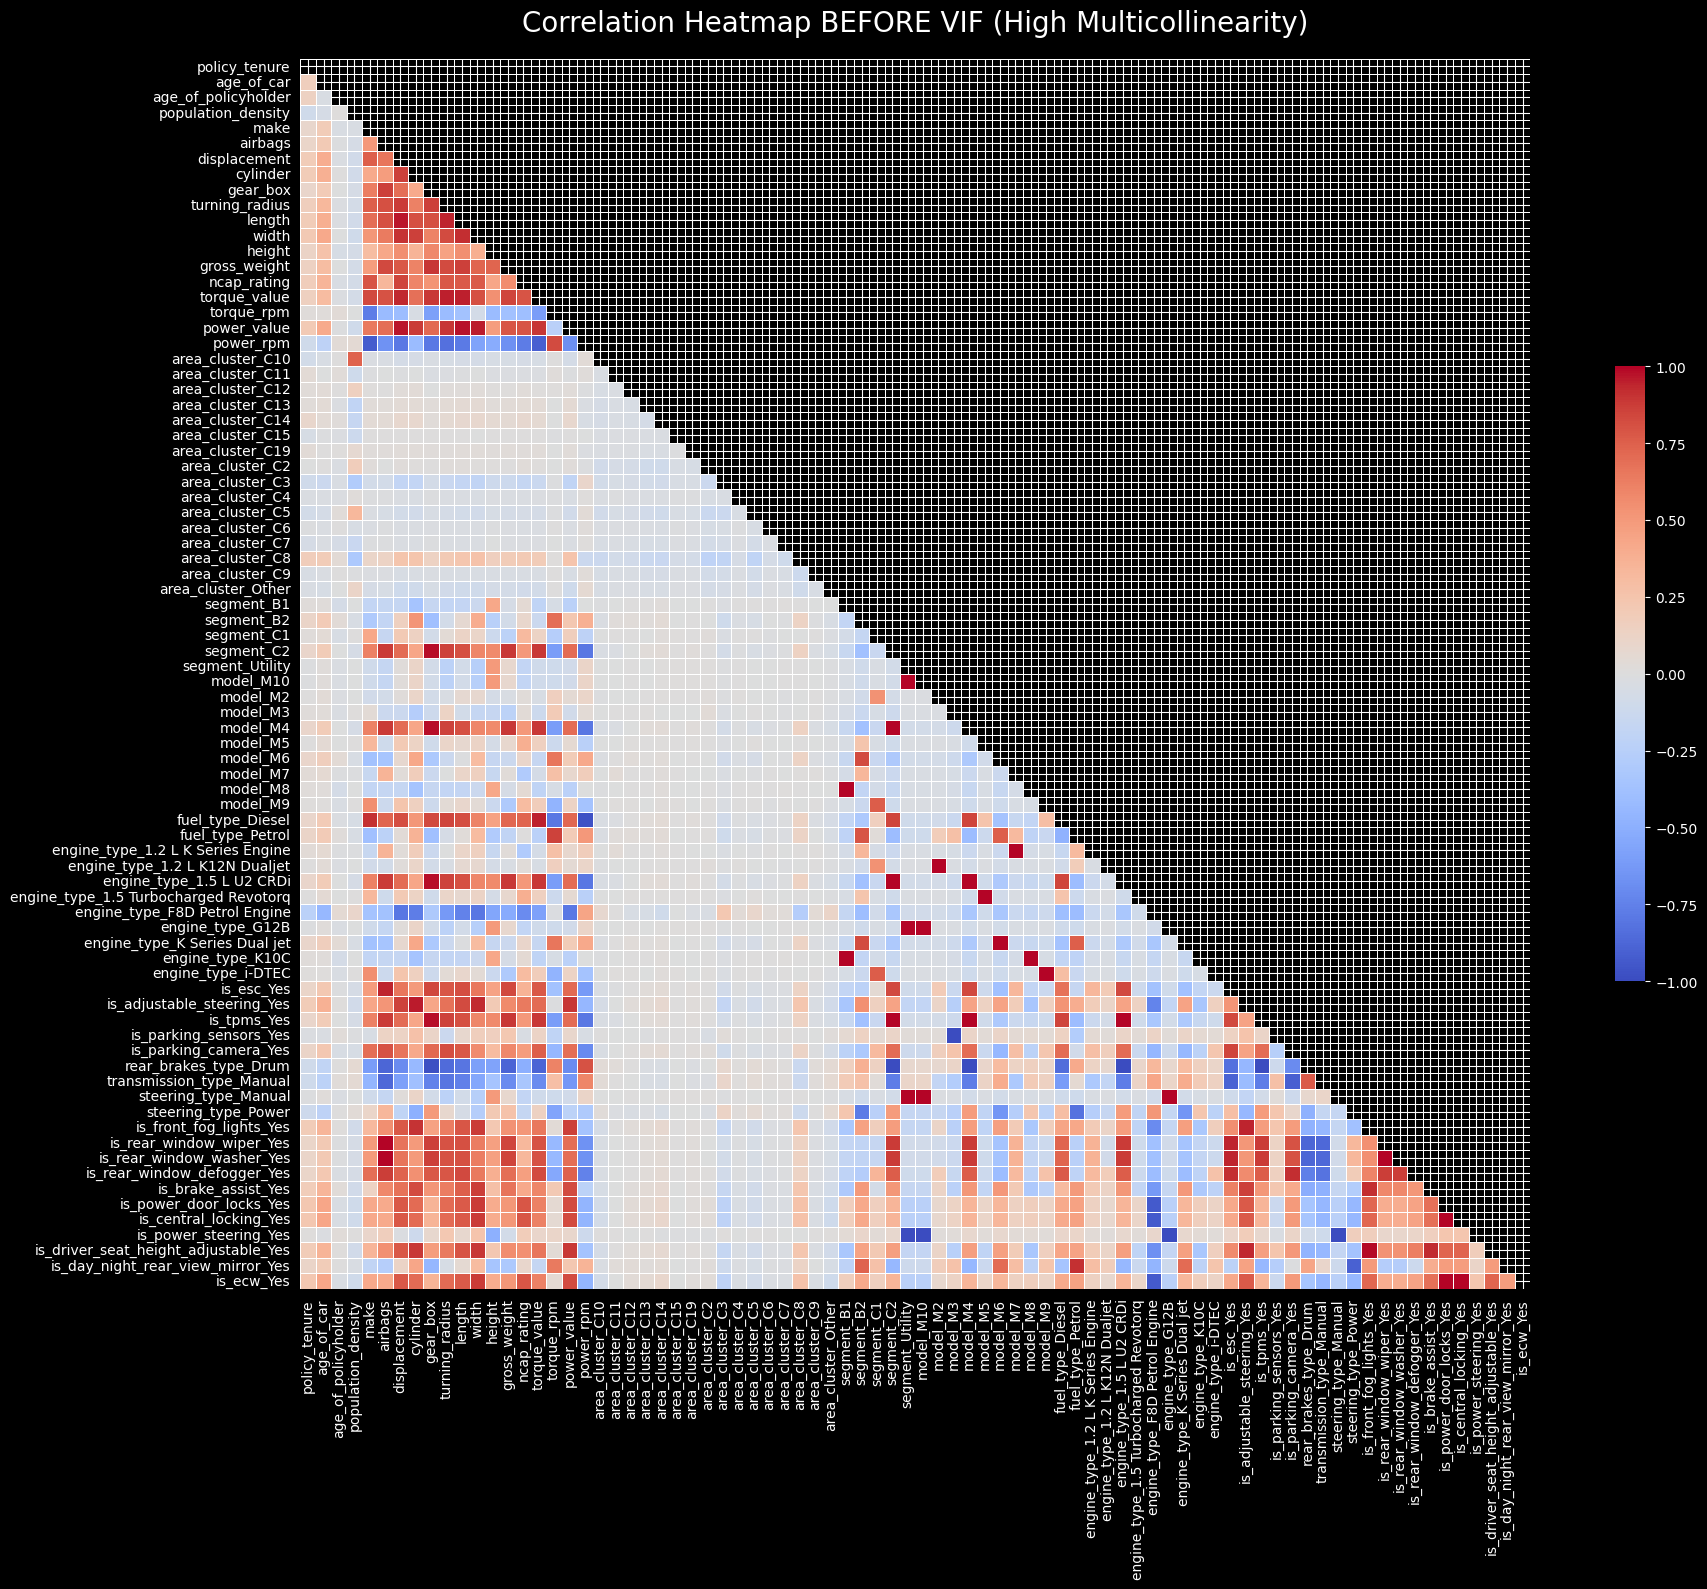

In [6]:
X, y = clean_insurance_data(df_claim)
plot_correlation_heatmap(X, "Correlation Heatmap BEFORE VIF (High Multicollinearity)")


In [7]:
from stats_utils import calculate_and_drop_vif

X_clean, dropped_features = calculate_and_drop_vif(X)

Starting VIF Multicollinearity Check...

----------------------------------------


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'make' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'airbags' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'displacement' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'cylinder' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'gear_box' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'turning_radius' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'length' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'width' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'height' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'gross_weight' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'ncap_rating' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'torque_value' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'torque_rpm' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'power_value' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'power_rpm' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'segment_B1' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'segment_B2' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'segment_C1' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'segment_C2' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'segment_Utility' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'model_M10' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'model_M2' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'model_M3' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'model_M4' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'model_M5' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'model_M6' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'model_M7' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'model_M8' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'model_M9' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'fuel_type_Diesel' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'fuel_type_Petrol' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'engine_type_1.2 L K Series Engine' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'engine_type_1.2 L K12N Dualjet' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'engine_type_1.5 L U2 CRDi' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'engine_type_1.5 Turbocharged Revotorq' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'engine_type_F8D Petrol Engine' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'engine_type_G12B' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'engine_type_K Series Dual jet' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'engine_type_K10C' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'engine_type_i-DTEC' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'is_esc_Yes' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'is_adjustable_steering_Yes' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'is_tpms_Yes' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'is_parking_sensors_Yes' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'is_parking_camera_Yes' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'rear_brakes_type_Drum' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'steering_type_Manual' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'is_rear_window_wiper_Yes' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'is_power_door_locks_Yes' (VIF: inf)


/home/rev8/.local/share/conda/envs/ds/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped collinear feature: 'is_central_locking_Yes' (VIF: inf)
Dropped collinear feature: 'is_driver_seat_height_adjustable_Yes' (VIF: 178.12)
Dropped collinear feature: 'is_front_fog_lights_Yes' (VIF: 18.56)
Dropped collinear feature: 'population_density' (VIF: 17.91)
Dropped collinear feature: 'is_rear_window_washer_Yes' (VIF: 12.83)
Dropped collinear feature: 'steering_type_Power' (VIF: 11.69)
Dropped collinear feature: 'area_cluster_C8' (VIF: 8.20)
----------------------------------------
VIF Check Complete!
Features dropped: 56


In [8]:
print(dropped_features)

['make', 'airbags', 'displacement', 'cylinder', 'gear_box', 'turning_radius', 'length', 'width', 'height', 'gross_weight', 'ncap_rating', 'torque_value', 'torque_rpm', 'power_value', 'power_rpm', 'segment_B1', 'segment_B2', 'segment_C1', 'segment_C2', 'segment_Utility', 'model_M10', 'model_M2', 'model_M3', 'model_M4', 'model_M5', 'model_M6', 'model_M7', 'model_M8', 'model_M9', 'fuel_type_Diesel', 'fuel_type_Petrol', 'engine_type_1.2 L K Series Engine', 'engine_type_1.2 L K12N Dualjet', 'engine_type_1.5 L U2 CRDi', 'engine_type_1.5 Turbocharged Revotorq', 'engine_type_F8D Petrol Engine', 'engine_type_G12B', 'engine_type_K Series Dual jet', 'engine_type_K10C', 'engine_type_i-DTEC', 'is_esc_Yes', 'is_adjustable_steering_Yes', 'is_tpms_Yes', 'is_parking_sensors_Yes', 'is_parking_camera_Yes', 'rear_brakes_type_Drum', 'steering_type_Manual', 'is_rear_window_wiper_Yes', 'is_power_door_locks_Yes', 'is_central_locking_Yes', 'is_driver_seat_height_adjustable_Yes', 'is_front_fog_lights_Yes', 'pop


$$VIF = \frac{1}{1 - R^2}$$

When one of the variables, like per example `engine_type_K10C`, can be 100% predicted by other variable, its $R^2$ score is exactly $1.0$.
That's why we have the warning of divided by zero, and the VIF is infinite.

This is a win because we are eliminating the multicollinearity from the model.

per example, inside some models, all those variables don't change across them.

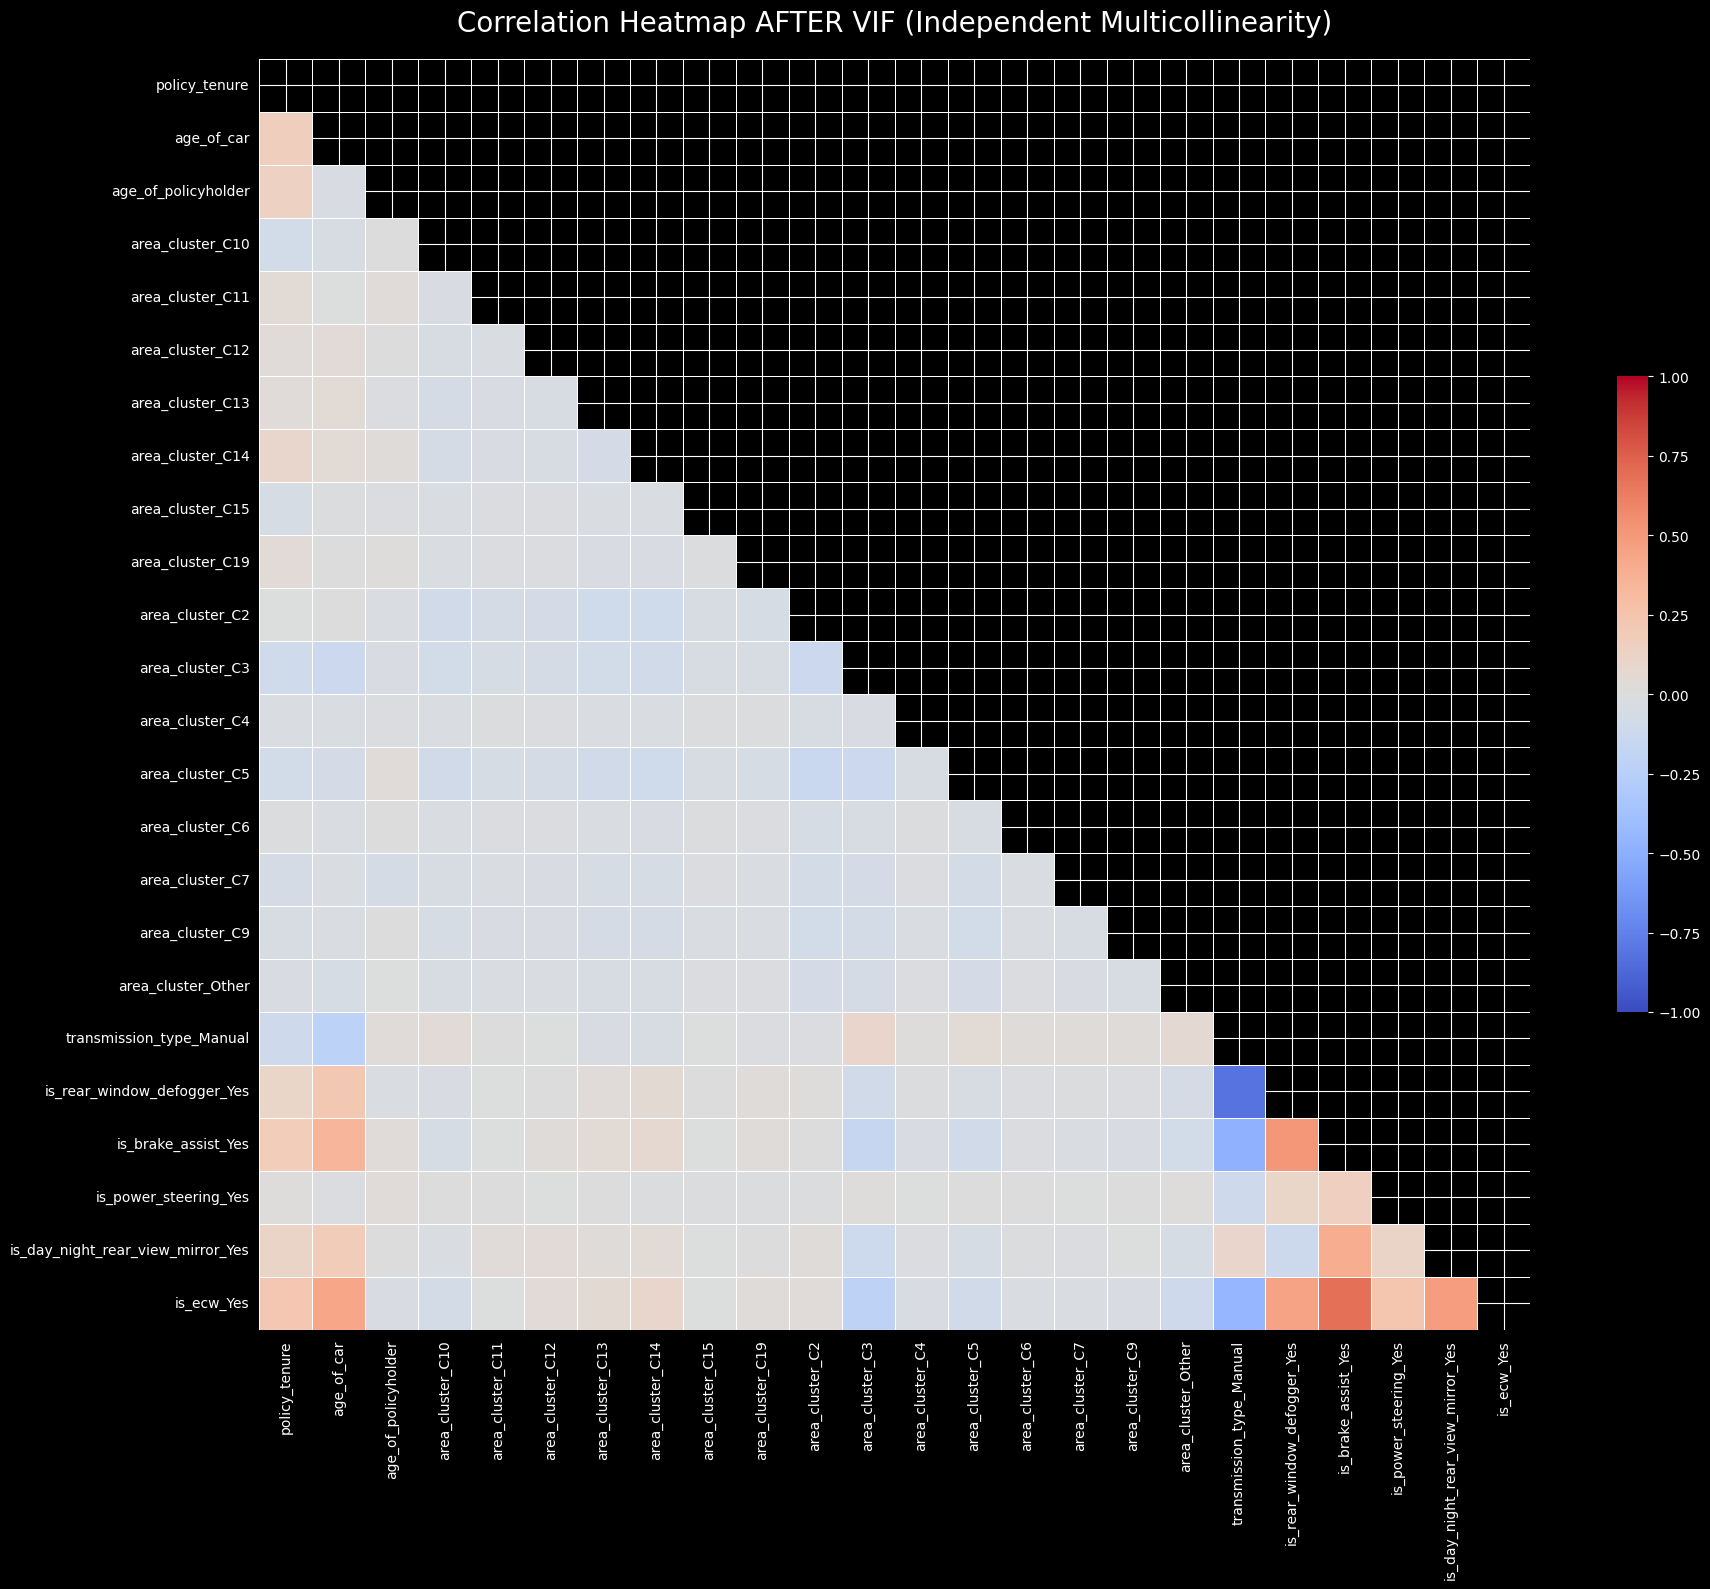

In [9]:
plot_correlation_heatmap(X_clean, "Correlation Heatmap AFTER VIF (Independent Multicollinearity)")


In [10]:
from stats_utils import stepwise_selection_logit

print(X_clean.columns.tolist())
best_model, final_features = stepwise_selection_logit(X_clean, y, threshold_in=0.05, threshold_out=0.05)

['policy_tenure', 'age_of_car', 'age_of_policyholder', 'area_cluster_C10', 'area_cluster_C11', 'area_cluster_C12', 'area_cluster_C13', 'area_cluster_C14', 'area_cluster_C15', 'area_cluster_C19', 'area_cluster_C2', 'area_cluster_C3', 'area_cluster_C4', 'area_cluster_C5', 'area_cluster_C6', 'area_cluster_C7', 'area_cluster_C9', 'area_cluster_Other', 'transmission_type_Manual', 'is_rear_window_defogger_Yes', 'is_brake_assist_Yes', 'is_power_steering_Yes', 'is_day_night_rear_view_mirror_Yes', 'is_ecw_Yes']
Starting Stepwise Selection...

----------------------------------------
Added:   'policy_tenure' (p-value: 0.0000)
Added:   'age_of_car' (p-value: 0.0000)
Added:   'area_cluster_C3' (p-value: 0.0015)
Added:   'area_cluster_C2' (p-value: 0.0022)
Added:   'is_brake_assist_Yes' (p-value: 0.0062)
Added:   'area_cluster_C14' (p-value: 0.0269)
Added:   'age_of_policyholder' (p-value: 0.0283)
Added:   'area_cluster_C4' (p-value: 0.0257)
Added:   'area_cluster_C10' (p-value: 0.0481)
Added:   'a

In [11]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_claim   No. Observations:                58592
Model:                          Logit   Df Residuals:                    58582
Method:                           MLE   Df Model:                            9
Date:                Mon, 23 Feb 2026   Pseudo R-squ.:                 0.01877
Time:                        20:15:44   Log-Likelihood:                -13669.
converged:                       True   LL-Null:                       -13930.
Covariance Type:            nonrobust   LLR p-value:                7.379e-107
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.2405      0.076    -42.579      0.000      -3.390      -3.091
policy_tenure           0.8462      0.044     19.136      0.000       0.760       0.933
age_of_car             -3.5342      0.349    -10.115      0.000      -4.219      -2.849
area_cluster_C3         0.1949      0.056      3.500      0.000       0.086       0.304
area_cluster_C2         0.1405      0.050      2.790      0.005       0.042       0.239
is_brake_assist_Yes     0.0946      0.037      2.535      0.011       0.021       0.168
age_of_policyholder     0.3080      0.136      2.258      0.024       0.041       0.575
area_cluster_C4         0.2916      0.148      1.968      0.049       0.001       0.582
area_cluster_C10       -0.1989      0.088     -2.271      0.023      -0.371      -0.027
area_cluster_C9        -0.1963      0.091     -2.158      0.031      -0.375      -0.018
=======================================================================================
"""

## Lowest chances to claim, ordered by importance:
1. The older the car (`age_of_car`) with -3.53
2. Area C9 and C10 (`area_cluster`) with -0.19

## Higher chances to claim, ordered by importance:
1. The longer someone has the policy (`policy_tenure`) with 0.84
2. The older the driver (`age_of_policyholder`) with 0.30

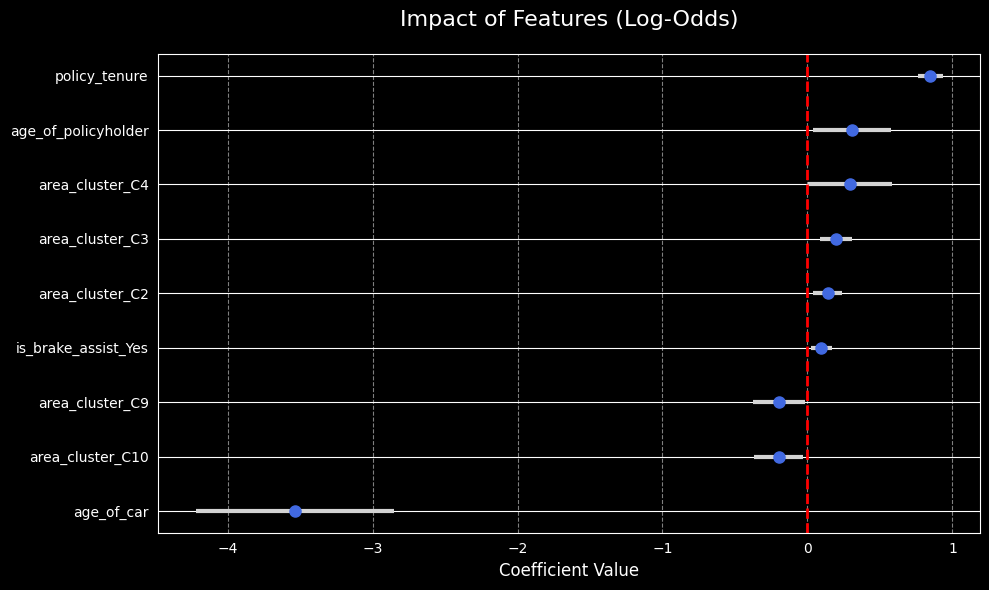

In [12]:
from stats_utils import plot_coef

plot_coef(best_model)


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier

seed = 42
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

logReg = 'Logistic Regression'
forest = 'Random Forest'
hist = 'HistGradientBoosting'

models = {
    logReg: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=seed),
    forest: RandomForestClassifier(class_weight='balanced', random_state=seed),
    hist: HistGradientBoostingClassifier(class_weight='balanced', random_state=seed)
}

param_grids = {
    logReg: {
        'C': [0.01, 0.1, 1.0, 10.0],
        'solver': ['liblinear', 'saga']
    },
    forest: {
        'n_estimators': [100, 300],
        'max_depth': [5, 10, 15],
        'min_samples_leaf': [2, 5, 10]
    },
    hist: {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_iter': [100, 300],
        'max_depth': [3, 5, 7],
        'l2_regularization': [0.0, 1.0]
    }
}

best_models = {}
best_scores = {}
import time


from sklearn.model_selection import train_test_split
if 'const' in X_clean.columns:
    X_clean = X_clean.drop('const', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.3, random_state=seed, stratify=y)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

for name in models.keys():
    print(f"Running Grid Search for {name}...")
    start_time = time.time()

    grid = GridSearchCV(
        estimator=models[name],
        param_grid=param_grids[name],
        scoring='roc_auc',
        cv=5,
        n_jobs=-1
    )

    grid.fit(X_train_scaled, y_train)

    elapsed_time = (time.time() - start_time) / 60

    best_models[name] = grid.best_estimator_
    best_scores[name] = grid.best_score_

    print(f"  -> Best Cross-Validated AUC: {grid.best_score_:.4f}")
    print(f"  -> Optimal Params: {grid.best_params_}")
    print(f"  -> Time taken: {elapsed_time:.2f} minutes\n")


Running Grid Search for Logistic Regression...


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


Intel(R) Extension for Scikit-learn enabled automatically.


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)
Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)
Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


Intel(R) Extension for Scikit-learn enabled automatically.
Intel(R) Extension for Scikit-learn enabled automatically.
Intel(R) Extension for Scikit-learn enabled automatically.


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)
Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


Intel(R) Extension for Scikit-learn enabled automatically.
Intel(R) Extension for Scikit-learn enabled automatically.


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)
Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)
Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)
Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)
Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


Intel(R) Extension for Scikit-learn enabled automatically.
Intel(R) Extension for Scikit-learn enabled automatically.
Intel(R) Extension for Scikit-learn enabled automatically.
Intel(R) Extension for Scikit-learn enabled automatically.
Intel(R) Extension for Scikit-learn enabled automatically.


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)
Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)
Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)
Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


Intel(R) Extension for Scikit-learn enabled automatically.
Intel(R) Extension for Scikit-learn enabled automatically.
Intel(R) Extension for Scikit-learn enabled automatically.
Intel(R) Extension for Scikit-learn enabled automatically.


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)
Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


Intel(R) Extension for Scikit-learn enabled automatically.
Intel(R) Extension for Scikit-learn enabled automatically.


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


Intel(R) Extension for Scikit-learn enabled automatically.
  -> Best Cross-Validated AUC: 0.6097
  -> Optimal Params: {'C': 0.01, 'solver': 'saga'}
  -> Time taken: 0.19 minutes

Running Grid Search for Random Forest...
  -> Best Cross-Validated AUC: 0.6494
  -> Optimal Params: {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 300}
  -> Time taken: 1.20 minutes

Running Grid Search for HistGradientBoosting...
  -> Best Cross-Validated AUC: 0.6511
  -> Optimal Params: {'l2_regularization': 0.0, 'learning_rate': 0.05, 'max_depth': 3, 'max_iter': 100}
  -> Time taken: 0.44 minutes



We are going to calculate what is the optimal threshold, because probably keeping it at 50%, we will miss a lot of claims.

# Taking a deep dive on the random forest best model.


DEFAULT THRESHOLD: 0.5000
OPTIMAL THRESHOLD: 0.4956


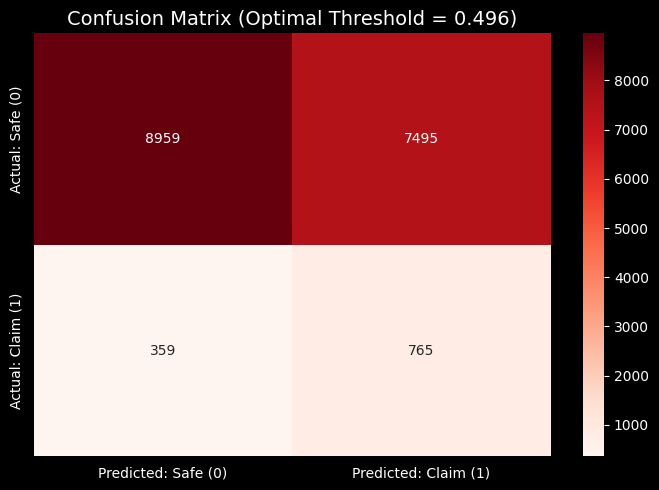


Classification Report (Using Optimal Threshold):
              precision    recall  f1-score   support

           0       0.96      0.54      0.70     16454
           1       0.09      0.68      0.16      1124

    accuracy                           0.55     17578
   macro avg       0.53      0.61      0.43     17578
weighted avg       0.91      0.55      0.66     17578



In [19]:
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import roc_curve

best_model = best_models[hist]

y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
j_scores = tpr - fpr
best_index = np.argmax(j_scores)
optimal_threshold = thresholds[best_index]
print("="*50)
print(f"DEFAULT THRESHOLD: 0.5000")
print(f"OPTIMAL THRESHOLD: {optimal_threshold:.4f}")
print("="*50)
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

cm_optimal = confusion_matrix(y_test, y_pred_optimal)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Predicted: Safe (0)', 'Predicted: Claim (1)'],
            yticklabels=['Actual: Safe (0)', 'Actual: Claim (1)'])
plt.title(f'Confusion Matrix (Optimal Threshold = {optimal_threshold:.3f})', fontsize=14)
plt.tight_layout()
plt.show()

print("\nClassification Report (Using Optimal Threshold):")
print(classification_report(y_test, y_pred_optimal))

### Precision (predicted claims that were claims divided by all predicted claims)
We achieved a precision of 9% (765 / (765 + 7495)).

While 9% might sound low at first glance,
the baseline standard for a claim in this dataset is only 6%.
This means if we pick any driver at random,
there is only a 6% chance they will file a claim.

We isolated a risk pool where the chance of a claim is nearly double the average.
The 7495 drivers flagged by the model who didn't crash yet are not necessarily safe drivers;
they possess the exact same high-risk features as those who did crash.
This risky behavior just hasn't caught up to them yet.

### Recall (predicted claims that were claims divided by all actual claims)
We achieved a recall of 68% (765 / (765 + 359)).

This means that out of the entire pool of drivers who actually got into an accident and filed a claim,
the model identified and flagged 58% of them in advance.

Instead of being blindsided by these payouts,
the business was warned about the majority of them ahead of time,
allowing us to price their policies correctly.

Calculating SHAP values


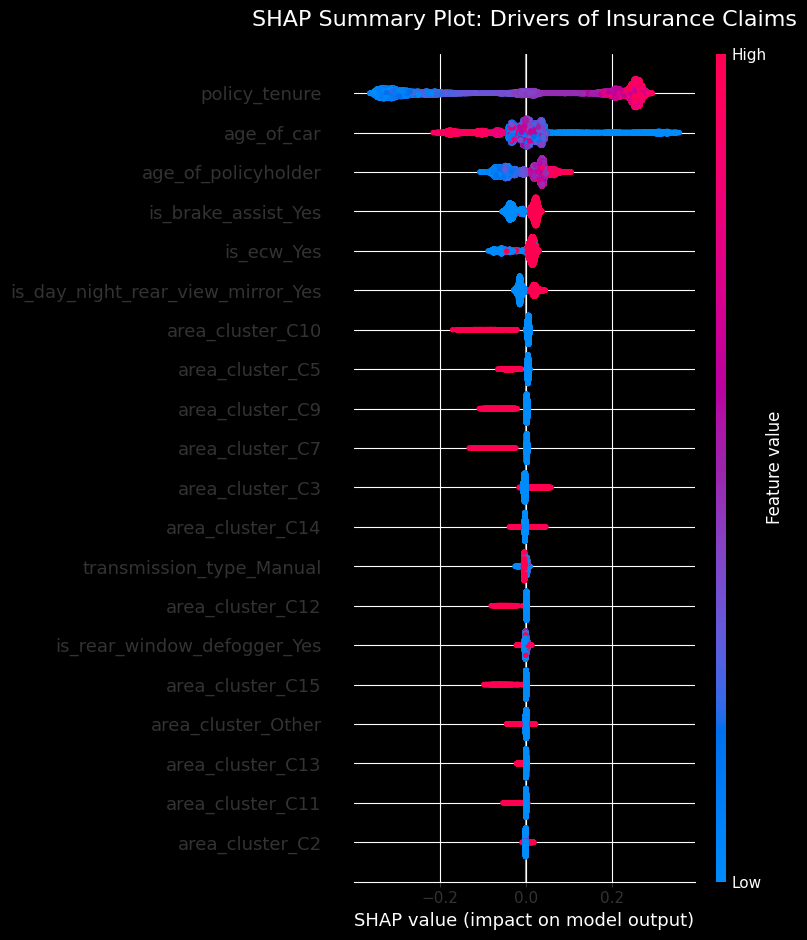

In [18]:
import numpy as np
import shap

print("Calculating SHAP values")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
elif len(shap_values.shape) == 3:
    shap_values_to_plot = shap_values[:, :, 1]
else:
    shap_values_to_plot = shap_values

plt.figure(figsize=(10, 6))
plt.title("SHAP Summary Plot: Drivers of Insurance Claims", fontsize=16, pad=20)
shap.summary_plot(shap_values_to_plot, X_test_scaled, plot_type="dot")

1. brand new policyholders are the safest drivers,
while long-term nature steadily increases claim risk.
2. The age of the vehicle acts as a massive risk shield.
Brand new cars are most likely to file a claim,
likely due to drivers using comprehensive coverage to fix minor damage on new investments.
3. Vehicules equipped with luxury features cluster together as a disctinct risk factor,
likely because their parts are significantly more expensive to repair,
easily pushing minor incidents over the deductible.